In [43]:
import pandas as pd
import numpy as np
import torch
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random
import os
import time
from ta import add_all_ta_features

In [44]:
'''for f in os.listdir('stocks'):
    if os.path.getsize('stocks/'+f)<7000:
        os.remove('stocks/'+f)
for f in os.listdir('etfs'):
    if os.path.getsize('etfs/'+f)<7000:
        os.remove('etfs/'+f)'''

"for f in os.listdir('stocks'):\n    if os.path.getsize('stocks/'+f)<7000:\n        os.remove('stocks/'+f)\nfor f in os.listdir('etfs'):\n    if os.path.getsize('etfs/'+f)<7000:\n        os.remove('etfs/'+f)"

In [45]:
l1=os.listdir('stocks')
l2=os.listdir('etfs')
device=torch.device('cuda:0')

In [46]:
def lin_reg(df): #feature neutralization to 1st order
    reg = linear_model.LinearRegression()
    reg.fit(df[:50,6:],df[:50,:5])
    return_arr = list(reg.predict(df[:51,6:]))
    
    for i in range(50,df.shape[0]-1):
        reg.fit(df[i-50:i-1,6:],df[i-49:i,:5])
        return_arr.append(reg.predict(np.expand_dims(df[i+1,6:],0))[0])
    return np.array(return_arr)

In [47]:
def raw_data(path):
    df=pd.read_csv(path).filter(['Open','High','Low','Close','Adj Close','Volume'])
    df=df.dropna()
    df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    return np.array(df)

def generate(path):
    df = raw_data(path)
    neutralized = lin_reg(df)
    df[:,:5] -= neutralized
    df=df[:-1]-df[1:]
    transprices=RobustScaler().fit(df[:,:5])
    df[:,:5]=transprices.transform(df[:,:5])
    maxprice=np.max(np.abs(df[:,:5]))
    maxvol=np.max(np.abs(df[:,5]))
    df[:,:5] /= maxprice
    df[:,5] /= maxvol
    for x in range(6,df.shape[1]):
        transinc=RobustScaler().fit(df[:,x].reshape(-1,1))
        df[:,x]=transinc.transform(df[:,x].reshape(-1,1))[:,0] #transform indicator
    df[:,6:] /= np.max(np.abs(df[:,6:]),0)
    np.nan_to_num(df,False,0,1,-1)
    return df,maxprice,maxvol,transprices,neutralized

In [48]:
random.shuffle(l1)
random.shuffle(l2)
test_path = 'etfs/'+l2[0]

#FFT
close_prices = raw_data(test_path)[:50][:, 3]
fft_result = torch.fft.fft(torch.Tensor(close_prices))
# frequency spectrum
frequencies = torch.fft.fftfreq(len(close_prices))
# amplitude spectrum
amplitude = np.abs(fft_result)

df1 = pd.DataFrame({"freq": frequencies, "amp": amplitude}, columns = ["freq", "amp"])
df1 = df1.loc[df1["freq"]>0]

frequencies = df1["freq"]
amplitude = df1["amp"]

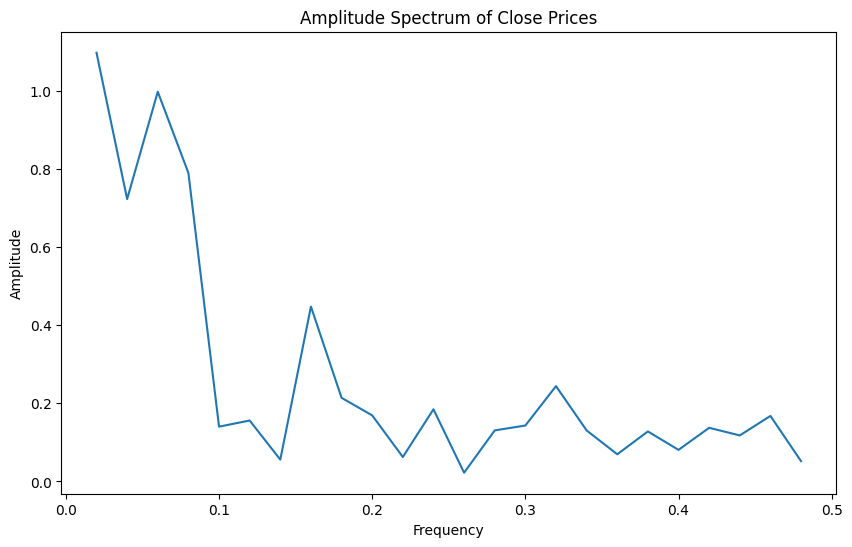

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(frequencies, amplitude)
plt.title('Amplitude Spectrum of Close Prices')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

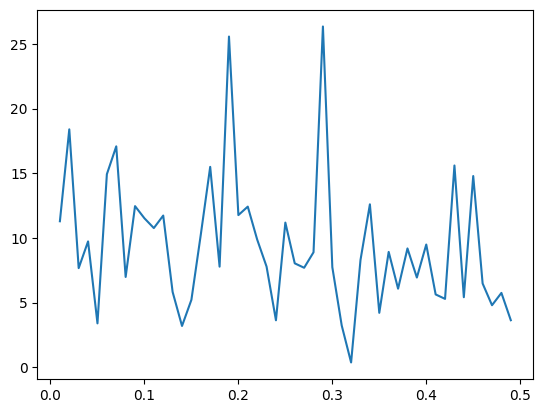

In [50]:
x = torch.randn(100)
X = torch.fft.fft(x)
XX = 2*torch.tensor(list(X[:50])+[X[50]/2]+list(np.zeros(99))+[X[50]/2]+list(X[51:]), dtype=torch.complex64)
xx = torch.fft.ifft(XX)
freq = np.array(torch.fft.fftfreq(100))
plt.plot(freq[freq>0],np.abs(X)[freq>0])
#plt.plot(np.arange(200)/200,xx)
#plt.plot(np.arange(200)/200,xx,'g.')
#plt.plot(np.arange(100)/100,x,'r.')

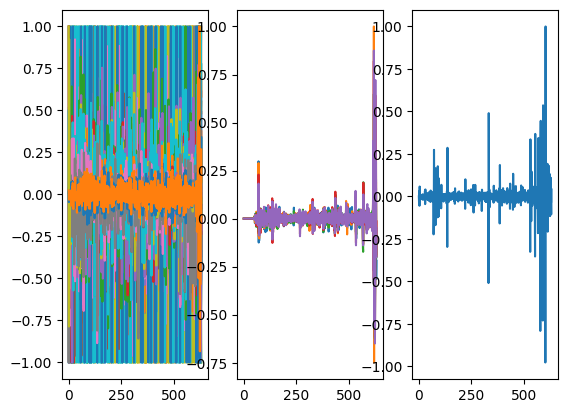

In [51]:
df,maxprice,maxvol,transa,neutralized = generate(test_path)
fig,ax = plt.subplots(1,3)
ax[0].plot(df)
ax[1].plot(df[:,:5])
ax[2].plot(df[:,5])
plt.show()

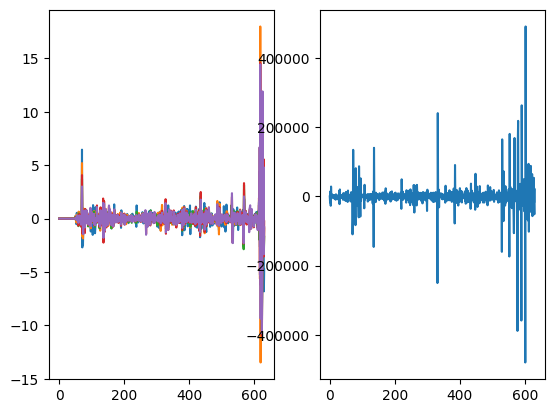

In [52]:
#restoring
def restorePreds(d,maxprice,maxvol,transa):
    df=d.copy()
    df[:,:5]=transa.inverse_transform(df[:,:5]*maxprice)
    df[:,5]=df[:,5]*maxvol
    return df
df=restorePreds(df,maxprice,maxvol,transa)
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(df[:,5])
plt.show()

In [53]:
def create(dataset,lback,lforward=1):
    X,y=[],[]
    for i in range(len(dataset)-lback-lforward+1):
        X.append(np.array(dataset[i:i+lback]))
        y.append(np.array(dataset[i+1:i+lback+lforward]))
    return torch.tensor(np.array(X)).float(),torch.tensor(np.array(y)).float()

In [54]:
lback=50
X_train,y_train=create(df,lback=lback)

PHASE 1a1: LSTM PREDICTION

In [55]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(input_size=92,hidden_size=200,num_layers=2,dropout=0.1,batch_first=True)
        self.l1=nn.Linear(200,92)
    def forward(self,x):
        x,_=self.lstm(x)
        x=self.l1(x)
        return x

In [56]:
model = LSTMModel()
model.to(device)

LSTMModel(
  (lstm): LSTM(92, 200, num_layers=2, batch_first=True, dropout=0.1)
  (l1): Linear(in_features=200, out_features=92, bias=True)
)

In [57]:
def l2loss(y_pred,y):
    return torch.mean(torch.square(y_pred-y))

In [58]:
def signloss(y_pred,y):
    #return torch.ceil(-y_pred[:,:,:5]*y[:,:,:5])
    return -torch.mean(torch.clip(y[:,:,:5]*y_pred[:,:,:5],0)*torch.abs(y[:,:,:5]))

In [59]:
def extloss(y_pred,y):
    return torch.square(torch.mean(torch.abs(y)-torch.abs(y_pred)))

In [60]:
def lstmloss(y_pred,y):
    l2 = l2loss(y_pred,y)*3
    sign = signloss(y_pred,y)
    ext = extloss(y_pred,y)*3
    #return torch.clip(2*(l2+sign),max=.5)
    return torch.clip(l2*(1+sign+ext),max=.5)

In [61]:
lr=1e-2
def train(n_epochs,dl,lforward=1):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr/lforward)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr/100/lforward, max_lr=lr/lforward,step_size_up=10000,mode="triangular2",cycle_momentum=False)
    for i in range(n_epochs):
        for X,y in dl:
            y = y.to(device)
            logits = 0
            y_pred = model(X.to(device))
            logits += lstmloss(y_pred,y[:,:lback])
            for j in range(1,lforward):
                y_pred = model(y_pred)
                logits += lstmloss(y_pred,y[:,j:j+lback])
            logits = logits/lforward
            optimizer.zero_grad()
            logits.backward()
            optimizer.step()
            scheduler.step()
    print(logits)
    torch.save(model.state_dict(),'lstmmodel.pt')

In [62]:
model.train()
lforward=1
for i in l2:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lback=lback, lforward=lforward)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(50, dl, lforward=lforward)

tensor(0.0244, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0218, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0204, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<DivBack

c:\Users\reiner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<DivBack

c:\Users\reiner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0215, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBack

c:\Users\reiner\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0193, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0397, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<DivBack

C:\Users\reiner\AppData\Local\Temp\ipykernel_12944\512763855.py:21: RuntimeWarning: invalid value encountered in divide
  df[:,6:] /= np.max(np.abs(df[:,6:]),0)


tensor(0.0841, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0205, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0073, device='cuda:0', grad_fn=<DivBack

PHASE 1a2: LSTM STAGE 2 (>1 PREDICTION)

In [47]:
'''model.train()
random.shuffle(l1);random.shuffle(l2)
for i in l2[:100]:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lback=lback,lforward=10)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,10)'''

"model.train()\nrandom.shuffle(l1);random.shuffle(l2)\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,_,_,_=generate(a)\n    X_train,y_train=create(df,lback=lback,lforward=10)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,10)"

In [21]:
model.load_state_dict(torch.load('lstmmodel.pt'))

<All keys matched successfully>

In [39]:
test_path='etfs/'+random.choice(l2)
#test_path='etfs/'+'SPY.csv'
print(test_path)

etfs/TBND.csv


In [40]:
model.eval() #NOT EVAL IN FINAL PREDICTIONS
df,a,b,transprices,neutralized = generate(test_path)
X_test,y_test = create(df, lback=lback)
dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=1)
qwer = True
for X,y in dl:
    if qwer:
        predicted = list(X.detach().numpy()[0])
        qwer = False
    predicted.append(model(X.to(device))[0][-1].detach().cpu().numpy())

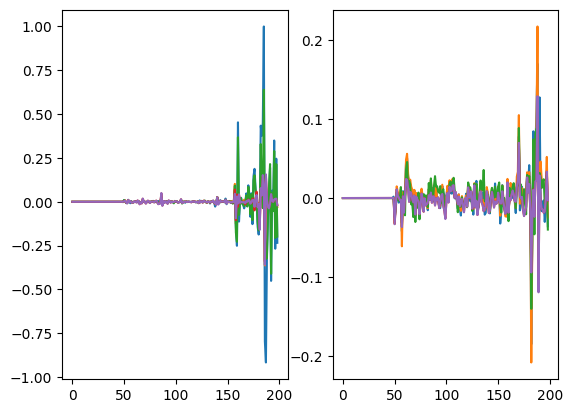

In [41]:
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(np.array(predicted)[:,:5])
plt.show()

(200, 6)
[array([ 25.19000053,  25.19000053,  25.19000053,  25.19000053,
        25.00432968, 100.        ])]


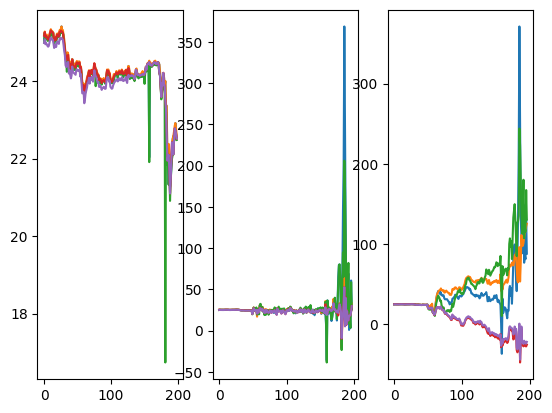

In [42]:
test_data=np.array(pd.read_csv(test_path).filter(['Open','High','Low','Close','Adj Close','Volume']))
print(test_data.shape)
fig,ax=plt.subplots(1,3)
ax[0].plot(test_data[1:,:5]) # original

predicted=np.array(predicted)
predicted=restorePreds(predicted,a,b,transprices)
test2=predicted[:,:5]+neutralized[:-1]
ax[1].plot(test2[1:-1]) # check that the transforms are correct, consider this 1 day preds

testult=[test_data[0]]
print(testult)
for i in range(predicted.shape[0]):
    testult.append(np.sum(predicted[:i+1],axis=0)[:6])
testult = np.array(testult)[:-1,:5]+neutralized[:-1]
ax[2].plot(np.array(testult)[1:-1,:5]) # results, cumulative error

In [26]:
def test_prep(arr):
    a=arr.copy()
    a /= np.max(np.abs(a))+1
    a = a[:-1]-a[1:]
    return a
test_data1 = test_prep(test_data[:-1,:5]) #original
test_data2 = test_prep(test2[:,:5]) #preds

pp=np.sum(np.ceil(test_data1))
pn=np.sum(np.ceil(-test_data1))
p=np.sum(np.ceil(test_data2))
n=np.sum(np.ceil(-test_data2))
tp=np.sum(np.ceil(test_data1)*np.ceil(test_data2))
tn=np.sum(np.ceil(-test_data1)*np.ceil(-test_data2))
recall=tp/p
precision=tp/pp
print('recall: ',recall)
print('precision: ',precision)
print('acc: ',(tp+tn)/(p+n))
print('f1: ',2*recall*precision/(recall+precision))

recall:  0.6453900709219859
precision:  0.610738255033557
acc:  0.6352
f1:  0.6275862068965518


Naive returns

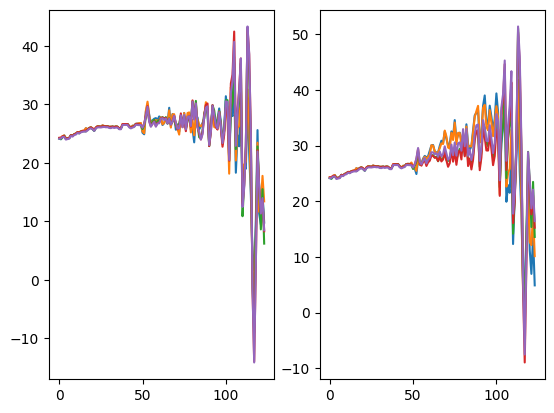

In [27]:
f,ax=plt.subplots(1,2)
ax[0].plot(test2[1:-1])
ax[1].plot(np.array(testult)[1:-1,:5])

(126, 5) (126, 5)


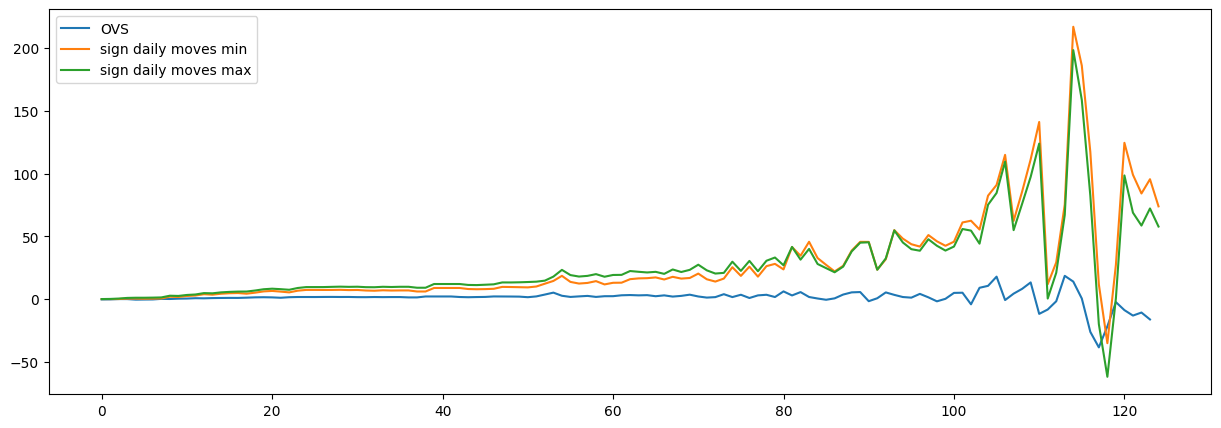

In [30]:
print(test2.shape,testult.shape)
# 3 is close
plt.figure(figsize=(15,5))
plt.plot(test2[1:-1,3]-test2[0,3], label=test_path.split('/')[1][:-4])
returns = [[],[]]
init_c_min = 100
init_c_max = 100
init_s_min = 0
init_s_max = 0
for i in range(1,testult.shape[0]):
    if testult[i,3]-testult[i-1,3]>0:
        if init_c_min>=test2[i-1,1]:
            init_c_min-=test2[i-1,1]; init_s_min+=1
        if init_c_max>=test2[i-1,2]:
            init_c_max-=test2[i-1,2]; init_s_max+=1
    else:
        if init_s_min>0:
            init_c_min+=test2[i-1,2]; init_s_min-=1
        if init_s_max>0:
            init_c_max+=test2[i-1,1]; init_s_max-=1
    returns[0].append(init_c_min+init_s_min*test2[i-1,3]-100)
    returns[1].append(init_c_max+init_s_max*test2[i-1,3]-100)
plt.plot(returns[0], label='sign daily moves min')
plt.plot(returns[1], label='sign daily moves max')
plt.plot()
plt.legend()
plt.show()
    


PHASE 1b1: LGBM

In [55]:
%pip install lightgbm


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [57]:
p_data = pd.read_csv(test_path).filter(['Open','High','Low','Close','Adj Close','Volume'])

In [58]:
p_data,_,_,_,_=generate(test_path)
p_data = pd.DataFrame(p_data, columns = np.arange(p_data.shape[1]))
p_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,...,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,-0.001248,-0.003167,-0.001617,-0.010985,-0.008708,-0.000107,-0.003346,-0.004161,0.000238,-0.000804,...,0.011064,0.021994,0.000950,-0.025534,-0.030635,-0.011516,0.007972,-0.001156,-0.001062,0.006046
std,0.104054,0.124594,0.113821,0.106283,0.153170,0.074387,0.059842,0.069498,0.117359,0.080974,...,0.131398,0.151171,0.126163,0.113489,0.157470,0.123405,0.119204,0.102856,0.100332,0.097118
min,-0.478897,-0.624825,-0.484607,-1.000000,-0.973991,-1.000000,-1.000000,-1.000000,-0.662664,-1.000000,...,-0.535356,-0.239614,-1.000000,-1.000000,-1.000000,-1.000000,-0.404489,-0.862182,-0.877986,-0.416385
25%,-0.061581,-0.058190,-0.058648,-0.067886,-0.056905,-0.001101,-0.000750,-0.001510,-0.010598,-0.000324,...,-0.041601,-0.041761,-0.038895,-0.023988,-0.074614,-0.020857,-0.019261,-0.029522,-0.027781,-0.032431
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.052515,0.055905,0.055448,0.046209,0.057190,0.001314,0.000495,0.000704,0.010905,0.001166,...,0.040308,0.048051,0.047222,0.021660,0.065911,0.033086,0.006901,0.032004,0.030367,0.027982
max,0.604423,0.537029,0.504568,0.650140,0.871724,0.877156,0.383298,0.479657,1.000000,0.531736,...,1.000000,1.000000,0.796596,0.079245,0.185482,0.280771,1.000000,1.000000,1.000000,1.000000


In [59]:
total_start_time = time.time()

for col in p_data.columns:
    # Record start time for the column
    start_time = time.time()
    
    # Load data
    X = pd.DataFrame(p_data)
    y = pd.Series(p_data[col])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }

    # Train the model
    num_round = 100
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Record end time for the column
    end_time = time.time()
    column_runtime = end_time - start_time
    
    print(f'===== Column "{col}" =====')
    print(f'Runtime: {column_runtime:.5f}s')
    print(f'RMSE: {rmse}')

# Calculate total runtime
total_end_time = time.time()
total_runtime = total_end_time - total_start_time
print(f'\nTotal runtime: {total_runtime:.5f}s')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's rmse: 0.0212766
===== Column "0" =====
Runtime: 0.15548s
RMSE: 0.021276602208382064
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0452219
===== Column "1" =====
Runtime: 0.15747s
RMSE: 0.04522190766538277
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.0295322
===== Column "2" =====
Runtime: 0.15947s
RMSE: 0.02953222383056141
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's rmse: 0.0884411
===== Column "3" =====
Runtime: 0.15648s
RMSE: 0.08844105878877184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 0.0893799
===== Column "4" =====
Runtime: 0.14651s
RM